# Traffic Sign Vision Transformer

In [ ]:
# hide
!pip install deepspeed
!pip install --upgrade wandb
import copy
from functools import partial
import multiprocessing as mp
from pathlib import Path
from typing import Any, Callable, List, Tuple

from deepspeed.ops.adam import FusedAdam
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from sklearn.model_selection import train_test_split
import torch
from torch.distributions.bernoulli import Bernoulli
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import io, transforms
# from torchvision.utils import Image, ImageDraw
from torchvision.transforms.functional import to_pil_image
from tqdm.auto import tqdm

In [4]:
# Image parameters
TRAIN_FILES = "../input/gtsrb-german-traffic-sign/Test"
IMAGE_SIZE = 256
PATCH_SIZE = 16
ZERO_PCT = 0.1
PATCHES_PER_ROW = (IMAGE_SIZE // PATCH_SIZE)
NUM_PATCHES = PATCHES_PER_ROW ** 2
RGB_CHANNELS = 3
NUM_PIXELS = PATCH_SIZE ** 2 * RGB_CHANNELS
VALID_IMAGES = 5
TOPK = 10      

# Training parameters
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4

# Transformer parameters
N_HEADS = 8
N_LAYERS = 6

# Update constants
TEMPERATURE_S = 0.1
TEMPERATURE_T = 0.05
CENTER_MOMENTUM = 0.9
TEACHER_MOMENTUM = 0.995

In [5]:
class ImageData(Dataset):
    def __init__(self, files: List[str]):
        self.files = files
        self.randcrop_big = transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=(0.5, 1.0))
        self.randcrop_small = transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE))
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        img = io.read_image(self.files[i])
        img1 = self.randcrop_big(img)
        img2 = self.randcrop_small(img)
        if img.shape[0] == 1:
            img1 = torch.cat([img1]*3)
            img2 = torch.cat([img2]*3)

        return img1, img2


class CollateFn:
    def reshape(self, batch):
        patches = torch.stack(batch)\
                    .unfold(2, PATCH_SIZE, PATCH_SIZE)\
                    .unfold(3, PATCH_SIZE, PATCH_SIZE)

        num_images = len(patches)
        patches = patches.reshape(
            num_images,
            RGB_CHANNELS, 
            NUM_PATCHES, 
            PATCH_SIZE, 
            PATCH_SIZE
        )
        patches.transpose_(1, 2)
        
        return patches.reshape(num_images, NUM_PATCHES, -1) / 255.0 - 0.5
        
    def __call__(
        self, batch: List[Tuple[torch.Tensor, torch.Tensor]]
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        x1, x2 = zip(*batch)

        return self.reshape(x1), self.reshape(x2)

In [6]:
# hide
class ImageOriginalData(Dataset):
    def __init__(self, files: List[str]):
        self.files = files
        self.resize = transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        img = io.read_image(self.files[i])
        if img.shape[0] == 1:
            img = torch.cat([img]*3)

        return self.resize(img)
    
class CollateSingleImage(CollateFn):    
    def __call__(
        self, batch: List[torch.Tensor]
    ) -> torch.FloatTensor:
        return self.reshape(batch)
    
files = [str(file) for file in Path(TRAIN_FILES).glob("*.png")]
train_files, valid_files = train_test_split(files, test_size=0.15, random_state=42)

train_data = ImageData(train_files)
train_dl = DataLoader(
    train_data, 
    BATCH_SIZE, 
    shuffle=True, 
    drop_last=True, 
    num_workers=4,
    pin_memory=True,
    collate_fn=CollateFn(),
)

valid_data = ImageOriginalData(valid_files)
valid_dl = DataLoader(
    valid_data, 
    BATCH_SIZE*2, 
    shuffle=False, 
    drop_last=False, 
    num_workers=4,
    pin_memory=True,
    collate_fn=CollateSingleImage(),
)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
x, y = next(iter(train_dl))
x2 = next(iter(valid_dl))
(x.shape, y.shape), (x2.shape)

((torch.Size([16, 256, 768]), torch.Size([16, 256, 768])),
 torch.Size([32, 256, 768]))

In [8]:
class Model(nn.Module):
    def __init__(self, d_model, n_head, n_layers):
        super().__init__()
        # transformer
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # positional embedding
        w_pos = torch.randn(NUM_PATCHES, d_model) / d_model ** 0.5
        cls_token = torch.randn(1, d_model) / d_model ** 0.5
        self.register_parameter("pos_embed", nn.Parameter(w_pos))
        self.register_parameter("cls_token", nn.Parameter(cls_token))

        # pixel projection
        self.linear = nn.Linear(2 * d_model, d_model)
        self.norm1 = nn.LayerNorm(2 * d_model, elementwise_affine=False)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        batch_size = len(x)
        position = torch.stack([self.pos_embed] * batch_size)
        x = torch.cat([x, position], dim=-1)
        pixel_proj = self.norm2(F.relu(self.linear(self.norm1(x))))
        batched_cls_token = torch.stack([self.cls_token]*batch_size)
        cls_x = torch.cat([batched_cls_token, pixel_proj], dim=1)
        
        cls_x.transpose_(0, 1)
        return F.normalize(self.encoder(cls_x)[0, ...], dim=-1)

In [9]:
class HLoss:
    def __init__(self, temperature_t: float, temperature_s: float):
        self.temperature_t = temperature_t
        self.temperature_s = temperature_s
        
    def __call__(
        self, 
        t: torch.FloatTensor, 
        s: torch.FloatTensor, 
        center: torch.FloatTensor
    ) -> torch.FloatTensor:
        t = F.softmax((t.detach() - center) / self.temperature_t, dim=1)
        log_s = F.log_softmax(s / self.temperature_s, dim=1)

        return -(t * log_s).sum(dim=1).mean()

In [10]:
# hide
resize = transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))

def get_closest(embedding: torch.FloatTensor, i: int):
    similarity = embedding @ embedding[i,:].T
    scores, idx = similarity.topk(TOPK)
    return scores.cpu().numpy(), idx.cpu().numpy()

def get_closest_wandb_images(embedding: torch.FloatTensor, i: int, files: List[str]):
    main_img = to_pil_image(resize(io.read_image(files[i])))
    closest_imgs = [wandb.Image(main_img)]
    
    scores, idx = get_closest(embedding, i)
    
    for i, score in zip(idx, scores):
        img = to_pil_image(resize(io.read_image(files[i])))
        closest_imgs.append(
            wandb.Image(img, caption=f"{score:.4f}")
        )
        
    return closest_imgs

In [11]:
class LightningModel(pl.LightningModule):
    def __init__(
        self,
        teacher: nn.Module,
        lr: float,
        loss_fn: Callable,
        valid_files: List[str],
        dim: int,
        center_momentum: float,
        param_momentum: float,
    ):
        super().__init__()
        self.teacher = teacher
        self.student = copy.deepcopy(teacher)
        self.lr = lr
        self.loss_fn = loss_fn
        self.c_mom = center_momentum
        self.p_mom = param_momentum
        self.register_buffer("center", torch.zeros((1, dim)).float())
        self.valid_files = valid_files
        
        for p in self.teacher.parameters():
            p.requires_grad = False

    def loss_calculation(
        self,
        batch: Tuple[torch.FloatTensor, torch.FloatTensor],
    ) -> torch.FloatTensor:
        x1, x2 = batch
        
        s1, s2 = self.student(x1), self.student(x2)
        t1, t2 = self.teacher(x1), self.teacher(x2)
        
        loss = self.loss_fn(t1, s2, self.center) + self.loss_fn(t2, s1, self.center)
        
        emperical_center = F.normalize(
            torch.cat([t1, t2]).mean(dim=0, keepdims=True),
            dim=-1,
        )
        return loss, emperical_center

    def training_step(
        self, batch: Tuple[torch.FloatTensor, torch.FloatTensor], *args: List[Any]
    ) -> torch.Tensor:
        loss, emperical_center = self.loss_calculation(batch)
        self.log(name="Training loss", value=loss, on_step=True, on_epoch=True)
        
        self.center = F.normalize(
            self.c_mom * self.center + (1 - self.c_mom) * emperical_center,
            dim=-1,
        )
        for s_p, t_p in zip(self.student.parameters(), self.teacher.parameters()):
            t_p.data = self.p_mom * t_p.data + (1 - self.p_mom) * s_p.data
            
        return loss
    
    def validation_step(self, images: torch.FloatTensor, *args: List[Any]) -> None:
        return self.teacher(images)
        
    def validation_epoch_end(self, validation_step_outputs):
        valid_embeds = torch.cat([pred for pred in validation_step_outputs])
        columns = ["image"] + [f"closest_{i+1}" for i in range(TOPK)]
        indices = np.random.choice(len(self.valid_files), VALID_IMAGES, replace=False)
        rows = [get_closest_wandb_images(valid_embeds, i, self.valid_files) for i in indices]
        table = wandb.Table(data=rows, columns=columns)
        self.logger.experiment.log({f"epoch {self.current_epoch} results": table})
        
    def on_after_backward(self):
        if self.trainer.global_step % 50 == 0:  # don't make the tf file huge
            global_step = self.trainer.global_step
            for name, param in self.student.named_parameters():
                if "weight" in name and not "norm" in name and param.requires_grad:
                    self.logger.experiment.log(
                        {f"{name}_grad": wandb.Histogram(param.grad.cpu())}
                    )

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return FusedAdam(self.student.parameters(), lr=self.lr)

In [12]:

teacher = Model(NUM_PIXELS, N_HEADS, N_LAYERS)
h_loss = HLoss(TEMPERATURE_T, TEMPERATURE_S)
lightning_model = LightningModel(
    teacher, 
    LR,
    h_loss,
    valid_files,
    NUM_PIXELS,
    CENTER_MOMENTUM, 
    TEACHER_MOMENTUM,
)
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    gpus=torch.cuda.device_count(),
    gradient_clip_val=1.0,
    logger=logger,
    precision=16,
#     limit_train_batches=10,
    num_sanity_val_steps=0,
)
trainer.fit(lightning_model, train_dl, valid_dl)

Using /root/.cache/torch_extensions as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/fused_adam...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/fused_adam/build.ninja...
Building extension module fused_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/3] /usr/local/cuda/bin/nvcc  -DTORCH_EXTENSION_NAME=fused_adam -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1013\" -I/opt/conda/lib/python3.7/site-packages/deepspeed/ops/csrc/includes -isystem /opt/conda/lib/python3.7/site-packages/torch/include -isystem /opt/conda/lib/python3.7/site-packages/torch/include/torch/csrc/api/include -isystem /opt/conda/lib/python3.7/site-packages/torch/include/TH -isystem /opt/conda/lib/python3.7/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isys

wandb: Currently logged in as: stpeteishii (use `wandb login --relogin` to force relogin)


[3/3] c++ fused_adam_frontend.o multi_tensor_adam.cuda.o -shared -L/opt/conda/lib/python3.7/site-packages/torch/lib -lc10 -lc10_cuda -ltorch_cpu -ltorch_cuda -ltorch -ltorch_python -L/usr/local/cuda/lib64 -lcudart -o fused_adam.so
Loading extension module fused_adam...
Time to load fused_adam op: 34.17909502983093 seconds


Training: -1it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/plugins/precision/precision_plugin.py:138: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(parameters, clip_val)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [13]:
# hide
image_orig_data = ImageOriginalData(files)
image_orig_dl = DataLoader(
    image_orig_data, 
    BATCH_SIZE*2, 
    shuffle=False, 
    drop_last=False, 
    num_workers=4,
    pin_memory=True,
    collate_fn=CollateSingleImage(),
)

In [14]:
teacher = teacher.eval().to(device)
embedding = []
with torch.no_grad():
    for x in tqdm(image_orig_dl):
        out = teacher(x.to(device))
        embedding.append(out.cpu())
        
    embedding = torch.cat(embedding, dim=0)

  0%|          | 0/395 [00:00<?, ?it/s]

In [15]:
def plot_closest_pairs(embedding, i, files):
    img = to_pil_image(resize(io.read_image(files[i])))
    plt.imshow(img)
    scores, idx = get_closest(embedding, i)
    print(idx)
    print(scores)
    fig, axs = plt.subplots(2,5, figsize=(12,5))
    for j in range(10):
        i=idx[j]
        score=scores[j]
        r=j//5
        c=j%5
        img = to_pil_image(resize(io.read_image(files[i])))
        axs[r][c].imshow(img)
        axs[r][c].axis("off")
        axs[r][c].set_title(f"{score:.4f}")

    plt.show()

[   15 11059  7309  4747  6217  8486  6461    26  9366  4280]
[1.0000001  0.9999678  0.9998584  0.99983335 0.9998281  0.99979866
 0.99979067 0.99977386 0.9997441  0.99971074]


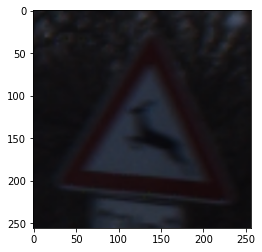

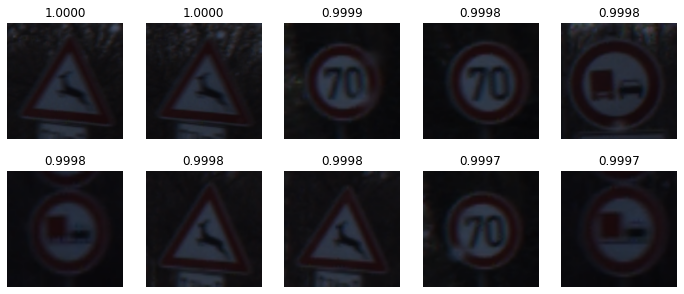

In [16]:
i = 15
plot_closest_pairs(embedding, i, files)

[   20  5015 11663  2384   958  6457  5286  2655  3424  8620]
[0.9999998  0.9993017  0.9986641  0.99862814 0.9985786  0.9984695
 0.9976385  0.9970472  0.99700147 0.9966534 ]


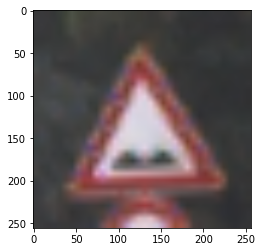

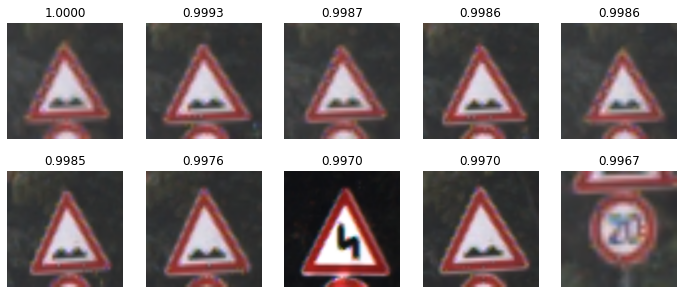

In [17]:
i = 20
plot_closest_pairs(embedding, i, files)

[   25  1422  3157 12579  7331  2568  3180  4310 10057   292]
[1.         0.96906424 0.95575887 0.9546078  0.9509693  0.94818103
 0.94636416 0.94501406 0.9447175  0.9443587 ]


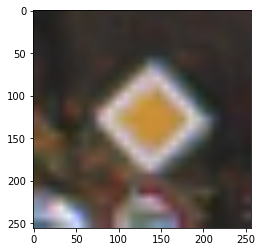

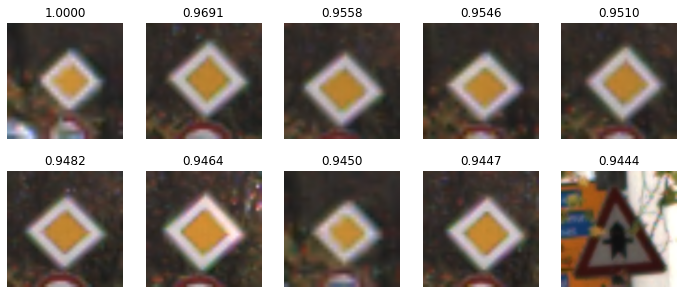

In [18]:
i = 25
plot_closest_pairs(embedding, i, files)